In [7]:

import _init_
from constants import *
from set_path import *
from config import *
from functions import *


# Get Temperature

In [2]:
file = '/g/data/jh2/av5889/freshquokka/quokka/extern/grackle_data_files/input/CloudyData_UVB=HM2012.h5'
# file = '/g/data/jh2/av5889/quokka_myrepo/quokka/extern/grackle_data_files/input/CloudyData_UVB=FG2011.h5'
grackle = h5py.File(file)
array = grackle['CoolingRates/Primordial/MMW'][()]
#density(1.e-6, 1.e4), redshift(0,15), temperature(10., 1.e9)
table = array[:,0,:]
table_nH   = np.logspace(-10., 4, array.shape[0])
table_temp = np.logspace(1,  9, array.shape[2])

In [3]:

i=0
bins = 200
egas_arr = np.logspace(-21., -5., bins)
nH_arr   = np.logspace(-7.0, 4.0, int(bins))
T = np.zeros((egas_arr.shape[0],nH_arr.shape[0]))

for egas in egas_arr:
    j=0
    for nH in nH_arr:
        C = (gamma - 1.) * egas / (boltzmann_constant_cgs*nH)
        minT = C*np.amin(table)
        maxT = C*np.amax(table)
        def func(T):
            mu = interpolate.interp2d(table_temp, table_nH, table,\
                              kind='linear', copy=True, bounds_error=False, fill_value=None)
            return C*mu(T,nH)[0] - T

        T[i,j] = scipy.optimize.toms748(func, minT, maxT)
        j+=1
    i+=1

    
# temperature_table = interpolate.RectBivariateSpline(egas_arr, nH_arr, T)


# Temeprature Distribution

yt : [INFO     ] 2024-05-10 09:54:42,002 Parameters: current_time              = 453738178240291.4
yt : [INFO     ] 2024-05-10 09:54:42,005 Parameters: domain_dimensions         = [ 64  64 512]
yt : [INFO     ] 2024-05-10 09:54:42,006 Parameters: domain_left_edge          = [ 0.0000e+00  0.0000e+00 -1.2072e+22]
yt : [INFO     ] 2024-05-10 09:54:42,007 Parameters: domain_right_edge         = [3.0180e+21 3.0180e+21 1.2072e+22]
yt : [INFO     ] 2024-05-10 09:54:42,697 Parameters: current_time              = 450159553147683.3
yt : [INFO     ] 2024-05-10 09:54:42,699 Parameters: domain_dimensions         = [ 64  64 512]
yt : [INFO     ] 2024-05-10 09:54:42,701 Parameters: domain_left_edge          = [ 0.0000e+00  0.0000e+00 -1.2072e+22]
yt : [INFO     ] 2024-05-10 09:54:42,702 Parameters: domain_right_edge         = [3.0180e+21 3.0180e+21 1.2072e+22]


11.467513557753955


yt : [INFO     ] 2024-05-10 09:54:43,339 Parameters: current_time              = 473396480413435.7
yt : [INFO     ] 2024-05-10 09:54:43,341 Parameters: domain_dimensions         = [ 64  64 512]
yt : [INFO     ] 2024-05-10 09:54:43,342 Parameters: domain_left_edge          = [ 0.0000e+00  0.0000e+00 -1.2072e+22]
yt : [INFO     ] 2024-05-10 09:54:43,344 Parameters: domain_right_edge         = [3.0180e+21 3.0180e+21 1.2072e+22]


19.888966287838542


yt : [INFO     ] 2024-05-10 09:54:43,966 Parameters: current_time              = 274249727334198.6
yt : [INFO     ] 2024-05-10 09:54:43,968 Parameters: domain_dimensions         = [ 64  64 512]
yt : [INFO     ] 2024-05-10 09:54:43,969 Parameters: domain_left_edge          = [ 0.0000e+00  0.0000e+00 -1.2072e+22]
yt : [INFO     ] 2024-05-10 09:54:43,971 Parameters: domain_right_edge         = [3.0180e+21 3.0180e+21 1.2072e+22]


24.613512936370302
5.374825500484965


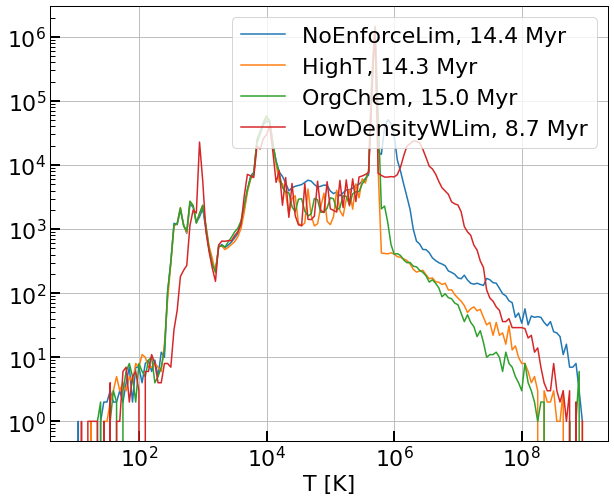

In [4]:
f = 'plt30000/'
label = ['NoEnforceLim', 'HighT', 'OrgChem', 'LowDensityWLim']
plt.figure(figsize=(10,8))
lev = 0
i=0
folder = ['NoEnforceLim/', 'OriginalChem/HighTLimit/', 'OriginalChem/', 'LowDensityWLim']
for fold in folder:
    data_path = os.path.join(scratch, 'findclouds/quokka_21Jun23/ZsolExtDir/', fold)
    infile    = os.path.join(data_path, 'metal_uniform.in')
    dom_min, dom_max, ncells = getdomain(infile)
    inputfile = os.path.join(data_path, f)
    ds   = yt.load(inputfile)
    data = ds.covering_grid(level=lev, left_edge=dom_min, dims=ds.domain_dimensions, num_ghost_zones=0)
    timestep = ds.current_time.to('Myr')

    rho_gas = np.array(data['gasDensity'])
    eint    = np.array(data['gasInternalEnergy'])
    egas0=eint

    cloudy_H_mass_fraction = 1. / (1. + 0.1 * 3.971)
    rho0 = rho_gas*cloudy_H_mass_fraction/hydrogen_mass_cgs


    logrho_arr = np.log10(nH_arr[:-1])
    logrho     = np.log10(rho0)
    delta_rho  = logrho_arr[1] - logrho_arr[0]
    idxrho     = (np.floor((logrho - np.amin(logrho_arr))/delta_rho)).astype('int')

    logEgas_arr = np.log10(egas_arr[:-1])
    logEgas     = np.log10(egas0)
    delta_egas  = logEgas_arr[1] - logEgas_arr[0]

    idxegas     = (np.floor((logEgas-np.amin(logEgas_arr))/delta_egas)).astype('int')


    wgt_rho  = (logrho - (np.amin(logrho_arr) + delta_rho*idxrho))/delta_rho
    wgt_egas = (logEgas - (np.amin(logEgas_arr) + delta_egas*idxegas))/delta_egas

    temp = (1.-wgt_rho)*(1.-wgt_egas)* T[tuple(idxegas)  , tuple(idxrho)]   +\
               wgt_rho *    wgt_egas * T[tuple(idxegas+1), tuple(idxrho+1)] +\
          (1. -wgt_rho)*    wgt_egas * T[tuple(idxegas+1), tuple(idxrho)]   +\
               wgt_rho *(1.-wgt_egas)* T[tuple(idxegas)  , tuple(idxrho+1)]  
    print(np.amin(temp))
    hist_temp = np.histogram((temp), bins=table_temp)
    plt.plot(table_temp[:-1], hist_temp[0], label=label[i] + ', %.1f'%(timestep) + ' Myr')
    i+=1
    
plt.xlabel('T [K]')
plt.yscale('log')
plt.xscale('log')
plt.legend()
plt.grid()

/jobfs/115349736.gadi-pbs/ipykernel_70747/3299282448.py:14: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  plot = ax.pcolormesh(table_nH, table_temp, np.transpose(table),\


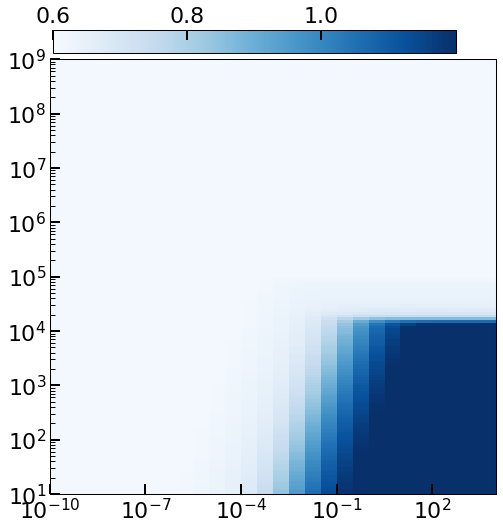

In [5]:
fig, ax = plt.subplots(1, 1, gridspec_kw = {'wspace':0.02, 'hspace':0.02},figsize=(8, 8))
i=0

cbarx = 0.13
cbheight = 0.04
cbary = 0.89
cblen = 0.7
dx1 = 0.25
cbtitlex = 0.1
cbtitley = 16.5
plane = (int)(ncells[1]/2)
# plane = 45

plot = ax.pcolormesh(table_nH, table_temp, np.transpose(table),\
                    vmin=0.6, vmax=1.2,
                    cmap='Blues')
cax = fig.add_axes([cbarx, cbary, cblen, cbheight])
fig.colorbar(plot, cax=cax, orientation='horizontal', ticks=(0.6, 0.8, 1.))
cax.xaxis.set_ticks_position('top')
ax.set_yscale('log')
ax.set_xscale('log')

yt : [INFO     ] 2024-05-10 09:54:45,607 Parameters: current_time              = 1346945668812244.0
yt : [INFO     ] 2024-05-10 09:54:45,608 Parameters: domain_dimensions         = [ 64  64 512]
yt : [INFO     ] 2024-05-10 09:54:45,610 Parameters: domain_left_edge          = [ 0.0000e+00  0.0000e+00 -1.2072e+22]
yt : [INFO     ] 2024-05-10 09:54:45,611 Parameters: domain_right_edge         = [3.0180e+21 3.0180e+21 1.2072e+22]
/jobfs/115349736.gadi-pbs/ipykernel_70747/3196920577.py:65: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  plot = ax[i].pcolormesh(yrange/kpc,zrange/kpc, np.transpose(temp[:,plane,:]),\
yt : [INFO     ] 2024-05-10 09:54:46,125 Parameters: current_time              = 1514097231421371.2
yt : [INFO     ]

1.15815503332148e-17


yt : [INFO     ] 2024-05-10 09:54:46,129 Parameters: domain_left_edge          = [ 0.0000e+00  0.0000e+00 -1.2072e+22]
yt : [INFO     ] 2024-05-10 09:54:46,130 Parameters: domain_right_edge         = [3.0180e+21 3.0180e+21 1.2072e+22]


4.615341719662301e-18


yt : [INFO     ] 2024-05-10 09:54:46,647 Parameters: current_time              = 1697933521704217.5
yt : [INFO     ] 2024-05-10 09:54:46,650 Parameters: domain_dimensions         = [ 64  64 512]
yt : [INFO     ] 2024-05-10 09:54:46,651 Parameters: domain_left_edge          = [ 0.0000e+00  0.0000e+00 -1.2072e+22]
yt : [INFO     ] 2024-05-10 09:54:46,652 Parameters: domain_right_edge         = [3.0180e+21 3.0180e+21 1.2072e+22]


1.4711197117766338e-17


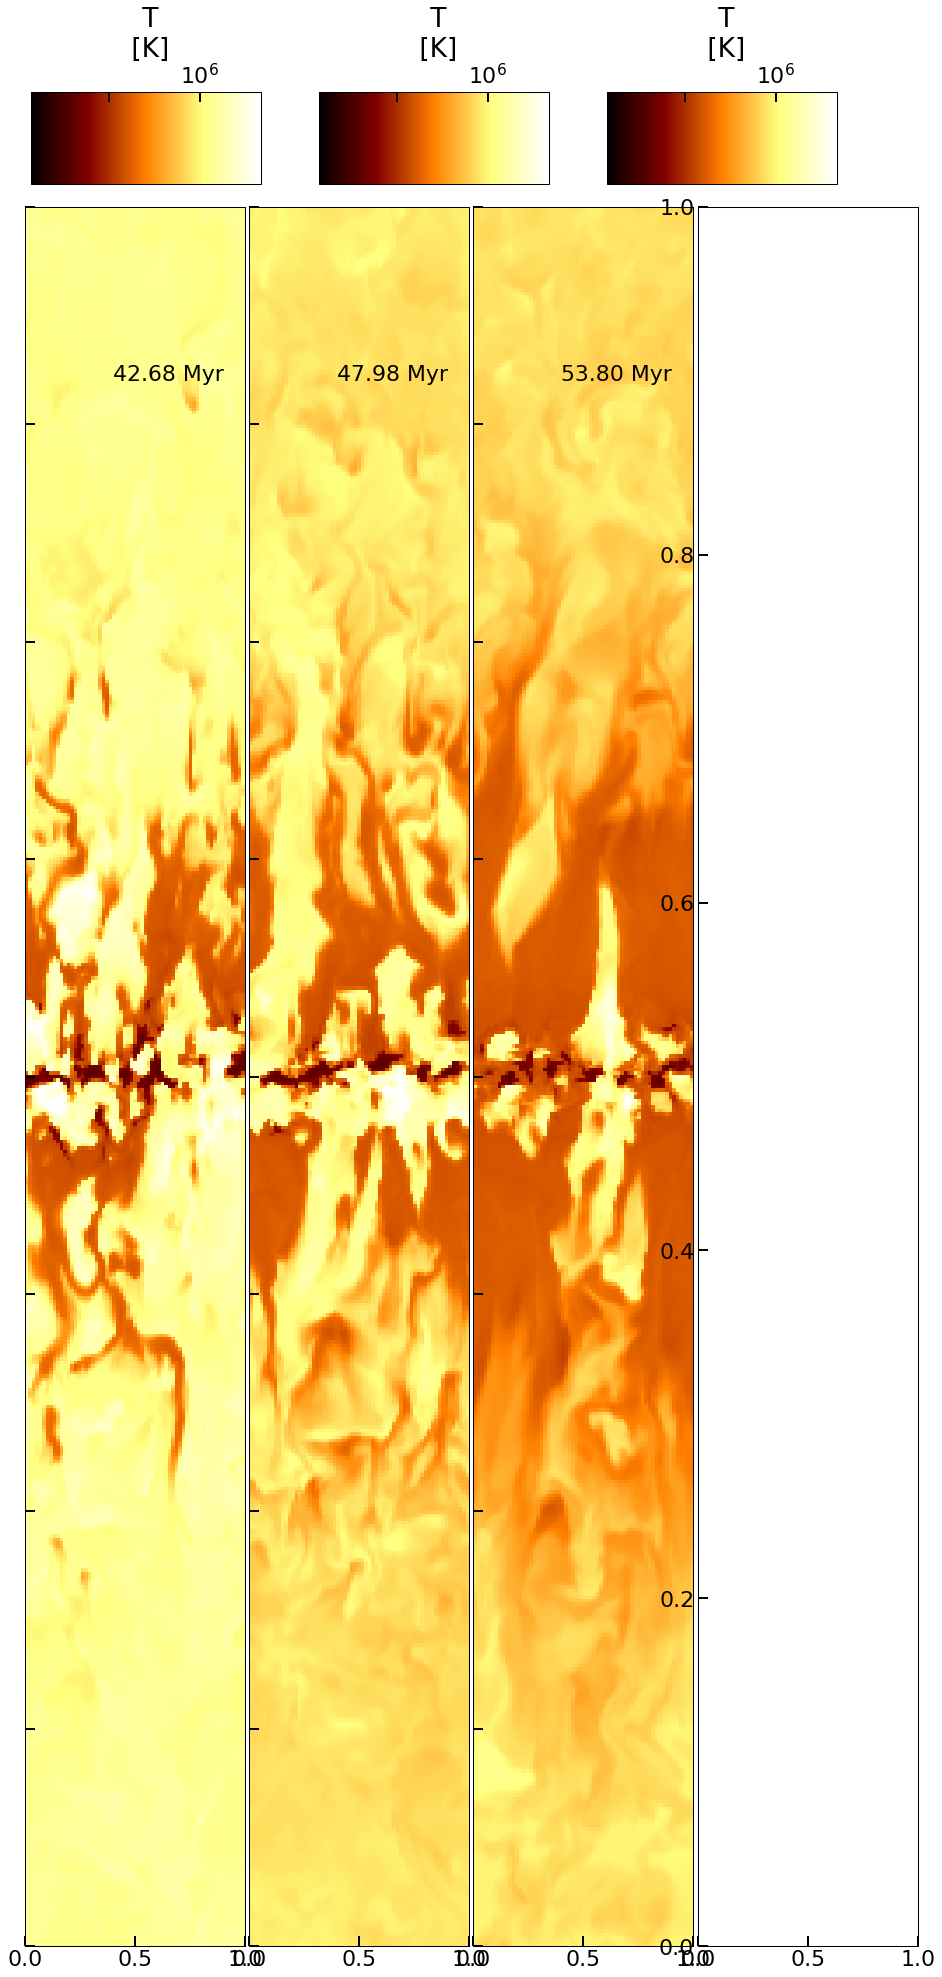

<Figure size 720x576 with 0 Axes>

In [6]:
fig, ax = plt.subplots(1, 4, gridspec_kw = {'wspace':0.02, 'hspace':0.02},figsize=(16, 32))
i=0

cbarx = 0.13
cbheight = 0.04
cbary = 0.89
cblen = 0.2
dx1 = 0.25
cbtitlex = 0.1
cbtitley = 16.5



f = 'plt105000/'
label = ['NoEnforceLim', 'HighT', 'OrgChem']
plt.figure(figsize=(10,8))
lev = 0
i=0
folder = ['NoEnforceLim/', 'OriginalChem/HighTLimit/', 'OriginalChem/'] #, 'LowDensityWLim']

for fold in folder:
    data_path = os.path.join(scratch, 'findclouds/quokka_21Jun23/ZsolExtDir/', fold)
    infile    = os.path.join(data_path, 'metal_uniform.in')
    dom_min, dom_max, ncells = getdomain(infile)
    zrange = np.linspace(dom_min[2], dom_max[2], (int(ncells[2])))
    xrange = np.linspace(dom_min[0], dom_max[0], (int(ncells[0])))
    yrange = np.linspace(dom_min[1], dom_max[1], (int(ncells[1])))
    plane = (int)(ncells[1]/2)
    dom_min, dom_max, ncells = getdomain(infile)
    inputfile = os.path.join(data_path, f)
    ds   = yt.load(inputfile)
    data = ds.covering_grid(level=lev, left_edge=dom_min, dims=ds.domain_dimensions, num_ghost_zones=0)
    timestep = ds.current_time.to('Myr')

    rho_gas = np.array(data['gasDensity'])
    eint    = np.array(data['gasInternalEnergy'])
    egas0=eint
    
    print(np.amin(eint))
    cloudy_H_mass_fraction = 1. / (1. + 0.1 * 3.971)
    rho0 = rho_gas*cloudy_H_mass_fraction/hydrogen_mass_cgs


    logrho_arr = np.log10(nH_arr[:-1])
    logrho     = np.log10(rho0)
    delta_rho  = logrho_arr[1] - logrho_arr[0]
    idxrho     = (np.floor((logrho - np.amin(logrho_arr))/delta_rho)).astype('int')

    logEgas_arr = np.log10(egas_arr[:-1])
    logEgas     = np.log10(egas0)
    delta_egas  = logEgas_arr[1] - logEgas_arr[0]

    idxegas     = (np.floor((logEgas-np.amin(logEgas_arr))/delta_egas)).astype('int')


    wgt_rho  = (logrho - (np.amin(logrho_arr) + delta_rho*idxrho))/delta_rho
    wgt_egas = (logEgas - (np.amin(logEgas_arr) + delta_egas*idxegas))/delta_egas

    temp = (1.-wgt_rho)*(1.-wgt_egas)* T[tuple(idxegas)  , tuple(idxrho)]   +\
               wgt_rho *    wgt_egas * T[tuple(idxegas+1), tuple(idxrho+1)] +\
          (1. -wgt_rho)*    wgt_egas * T[tuple(idxegas+1), tuple(idxrho)]   +\
               wgt_rho *(1.-wgt_egas)* T[tuple(idxegas)  , tuple(idxrho+1)]  

   
    plot = ax[i].pcolormesh(yrange/kpc,zrange/kpc, np.transpose(temp[:,plane,:]),\
                        norm=mcolors.LogNorm(vmin=2.e1, vmax=5.e7),
                        cmap='afmhot')
    cax = fig.add_axes([cbarx + i*dx1, cbary, cblen, cbheight])
    fig.colorbar(plot, cax=cax, orientation='horizontal', ticks=(3.e3,  1.e6,1.e8))
    cax.xaxis.set_ticks_position('top')
    cax.set_title(r" T" + "\n" + " [K]")
    ax[i].tick_params(axis='y', labelleft=False, labelright=False, right=False, left=True)
    ax[i].text(0.4, 0.9, '%.2f'%(timestep) + ' Myr', transform = ax[i].transAxes, color='black')
    i+=1


# ax[0].text( 0.4, 0.95, 'Res=%d'%(res) +' pc', transform = ax[0].transAxes, color='black')

# ax[0].grid()

yt : [INFO     ] 2024-05-09 15:35:15,588 Parameters: current_time              = 1346945668812244.0
yt : [INFO     ] 2024-05-09 15:35:15,590 Parameters: domain_dimensions         = [ 64  64 512]
yt : [INFO     ] 2024-05-09 15:35:15,591 Parameters: domain_left_edge          = [ 0.0000e+00  0.0000e+00 -1.2072e+22]
yt : [INFO     ] 2024-05-09 15:35:15,593 Parameters: domain_right_edge         = [3.0180e+21 3.0180e+21 1.2072e+22]
yt : [INFO     ] 2024-05-09 15:35:16,076 Parameters: current_time              = 1514097231421371.2
yt : [INFO     ] 2024-05-09 15:35:16,078 Parameters: domain_dimensions         = [ 64  64 512]
yt : [INFO     ] 2024-05-09 15:35:16,079 Parameters: domain_left_edge          = [ 0.0000e+00  0.0000e+00 -1.2072e+22]
yt : [INFO     ] 2024-05-09 15:35:16,080 Parameters: domain_right_edge         = [3.0180e+21 3.0180e+21 1.2072e+22]
yt : [INFO     ] 2024-05-09 15:35:16,555 Parameters: current_time              = 1697933521704217.5
yt : [INFO     ] 2024-05-09 15:35:16,557

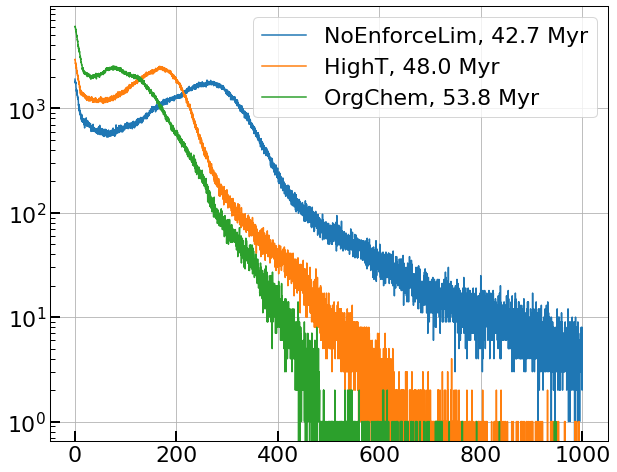

In [46]:
f = 'plt105000/'
vz_arr =np.linspace(0., 1000, 5000)
label = ['NoEnforceLim', 'HighT', 'OrgChem']
plt.figure(figsize=(10,8))
lev = 0
i=0
folder = ['NoEnforceLim/', 'OriginalChem/HighTLimit/', 'OriginalChem/']
for fold in folder:
    data_path = os.path.join(scratch, 'findclouds/quokka_21Jun23/ZsolExtDir/', fold)
    infile    = os.path.join(data_path, 'metal_uniform.in')
    dom_min, dom_max, ncells = getdomain(infile)
    inputfile = os.path.join(data_path, f)
    ds   = yt.load(inputfile)
    data = ds.covering_grid(level=lev, left_edge=dom_min, dims=ds.domain_dimensions, num_ghost_zones=0)
    timestep = ds.current_time.to('Myr')

    rho_gas = np.array(data['gasDensity'])
    vz = np.array(data['z-GasMomentum'])/rho_gas/kmps
    
    
    hist_vz = np.histogram(np.abs(vz), bins=vz_arr)
    plt.plot(vz_arr[:-1], hist_vz[0], label=label[i] + ', %.1f'%(timestep) + ' Myr')
    i+=1
    
plt.yscale('log')
# plt.xscale('log')
plt.legend()
plt.grid()